# Baseline Measurements for IMU Data Analysis

The point of this notebook is to qualitatively verify that the functions written to analyze IMU Data perform as expected. As a result, we are able to set a baseline for how fast the code can run.

This experiment is performed on a subset of IMU data collected by Lia (2017). This same data has already been investigated via Matlab code. The experiment presented here is considered a success if the results match the results generated by the previous analysis (e.g. Matlab code).

# Preamble

In [1]:
!pip install datashader

In [2]:
!pip install allantools

In [3]:
!python -m pip install "dask[complete]"

In [4]:
#calculating the allan deviation 
import allantools
#plotting datasets that fit in memory
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
#creating arrays that fit in memory
import numpy as np
#creating file readers
import pandas as pd
#reading datasets that are sizeable portion of memory
import dask.dataframe as dd
#plotting datasets that are a sizeable portion of memory
import datashader as ds
import datashader.transfer_functions as tf
from collections import OrderedDict
#accessing data saved to google drive inside colab
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
#Real IMU Data (Lia, 2017)
path = "/content/drive/MyDrive/Colab Notebooks/IMU Error Research/Datasets/combined_IMU_data.csv"

# Notes on Real Inertial Sensor Data

## Raw Data Known Parameters
- Sampling rates for real inertial sensors tend to be 1kHz - 10kHz
- The sampling rate for the inertial sensor data (Lia, 2017) is 10MHz
    - This subset of data spans 0 seconds -> 1357.88780 seconds 
        - This time span works out to be ~23 minutes of measurement

## Allan Deviation of Real Inertial Sensors
- Observed effects of Pink Noise on the Allan Deviation at $\tau=100$ sec

# Preparing the Data Subset

In [6]:
#ordered column names for real IMU data
cols = ["Index", "Sensor", "Laser"]

In [7]:
#read file into pandas df
%%time
pdf = pd.read_csv(path)

CPU times: user 30.1 s, sys: 9.95 s, total: 40.1 s
Wall time: 1min 1s


Reading is the slowest part of the process. The current method for plotting time series using Datashader requires slicing dataframe series in a way that is not available using a Dask dataframe (that is, without extra computation). 

Later, we use dask dataframes anyways. So, in the long run it will be better too refactor the plotting method to use a dask dataframe instead of pandas.

In [8]:
#rename columns
pdf.columns = cols

# Plotting Data as Time Series

In [9]:
def plot_time_series(df, time_col, signal_col, data_cols):

    """
    Plot a time series of the desired data.
    Use only if the overall behavior of the time series is needed.
    Do not use if specific values are needed.

    Args:
    df (pandas DataFrame):  DataFrame holding all data time series
    time_col (str):  Column name for the ordinal column
    signal_col (str):  Column name for the signal to plot
    data_cols (list of str):  List of column names for all signals in the DataFrame
                                Do not include ordinal column name.
                                Must be ordered.
    """
    
    #calculate the window size
    x_range = (df[time_col].iloc[0], df[time_col].iloc[-1])
    y_range = (0.8*df[signal_col].min(), 1.2*df[signal_col].max())

    cvs = ds.Canvas(x_range=x_range, y_range=y_range, plot_height=300, plot_width=900)
    aggs = OrderedDict((c, cvs.line(df, time_col, c)) for c in data_cols)
    img = tf.shade(aggs[signal_col])
    return img

CPU times: user 20.8 s, sys: 89.8 ms, total: 20.9 s
Wall time: 20.9 s


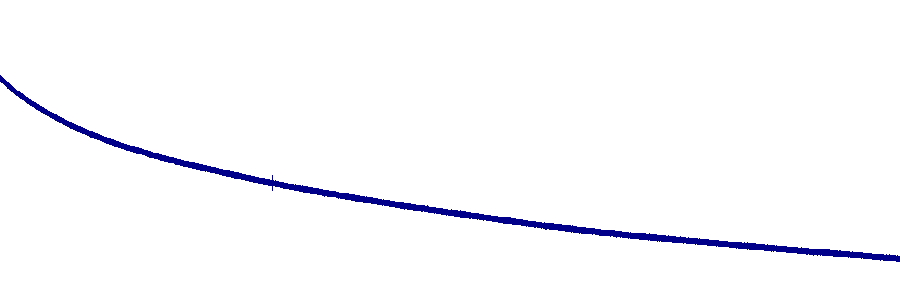

In [10]:
%%time
plot_time_series(pdf, "Index", "Sensor", ["Sensor", "Laser"])

CPU times: user 17 s, sys: 58.7 ms, total: 17.1 s
Wall time: 17.1 s


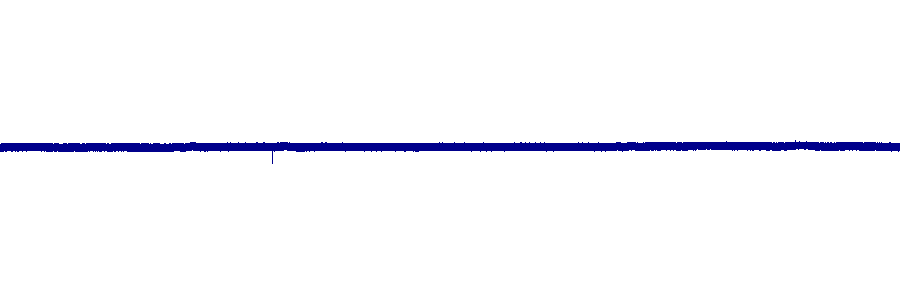

In [11]:
%%time
plot_time_series(pdf, "Index", "Laser", ["Sensor", "Laser"])

# The Allan Deviation

### Helper Functions

In [12]:
def log_straight_line(intercept, slope, x):
    """
    Create an array of values that follows:
    log(y) = (slope)*log(x) + intercept

    on log-log scale

    This is also the power law:
    y = (intercept)*(x**slope)

    Args:
    intercept (int or float):  The y-intercept of the loglog straight line, or
                                the coefficient of the power law.
    slope (float):  The slope of the loglog straight line, or the power law
                    exponent.
    x (array):  Inputs to the function.

    Returns:
    (array):  Outputs of the power law. 
    """
    return intercept*(np.power(x, slope))

In [13]:
def calculate_adev(series, title, filename, ref={"intercept":10, "slope":-0.5, "x":np.arange(1, 100)}):

    """
    Calculate the Allan Deviation of a time series.
    Save the figure in the local directory.

    Args:
    series (DataFrame, or array-like):  Time series values "y(t)"
    title (str):  Title of the figure
    filename (str):  Name of the saved figure file. Must include file extension
                        in string.
    ref (dict):  Dictoinary with parameters for plotting a reference line.
                        Defaults to {"intercept":10,
                                    "slope":-0.5,
                                    "x":np.arange(1, 100)}
    
    """

    t, a, _, n = allantools.adev(series, rate=1/10e-6)
    
    #take the square root of the variance
    a = np.sqrt(a)

    #create figure to plot
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)

    #place ADEV on axes
    adev, = ax.plot(t, a, label="Allan Deviation")

    #calculate reference line   
    y = log_straight_line(ref["intercept"], ref["slope"], ref["x"])
    #place reference line on axes
    line, = ax.plot(ref["x"], y, lw=4.0, label="Reference Slope {}".format(ref["slope"]))
    
    ax.set_yscale("log")
    ax.set_xscale("log")

    ax.set_xlabel("$\\tau$")
    ax.set_xlabel("$\sigma(\\tau)$")
    ax.set_title(title)
    ax.legend()
    ax.grid(b=True)

    plt.savefig(filename)
    plt.close()

    return 

### Plotting the Allan Deviation

In [14]:
#read the data into a dask dataframe
%%time
ddf = dd.read_csv(path)

CPU times: user 28.4 ms, sys: 124 ms, total: 152 ms
Wall time: 170 ms


In [15]:
ddf.columns = cols

In [16]:
#calculate the allan deviation and save a plot (Sensor)
%%time 
calculate_adev(ddf["Sensor"], "ADEV of Sensor Data (Lia 2017)", "sensor_adev.png")

CPU times: user 1min 58s, sys: 19.9 s, total: 2min 18s
Wall time: 1min 31s


In [17]:
#calculate the allan deviation and save a plot (Laser)
%%time 
calculate_adev(ddf["Laser"], "ADEV of Laser Data (Lia 2017)", "laser_adev.png")

CPU times: user 1min 57s, sys: 17.9 s, total: 2min 15s
Wall time: 1min 31s
